In [ ]:
import sys
sys.path.append('/Users/kiralyb/Documents/GitHub/CogModelingRNNsTutorial/')

In [2]:
#@title Imports + defaults settings.
#%load_ext autoreload
#%autoreload 2

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import warnings
import importlib

warnings.filterwarnings("ignore")

try:
    from google.colab import files
    _ON_COLAB = True
except:
    _ON_COLAB = False

from CogModelingRNNsTutorial import bandits
from CogModelingRNNsTutorial import disrnn
from CogModelingRNNsTutorial import hybrnn
from CogModelingRNNsTutorial import plotting
from CogModelingRNNsTutorial import rat_data
from CogModelingRNNsTutorial import rnn_utils

from scipy.io import loadmat

ModuleNotFoundError: No module named 'CogModelingRNNsTutorial'

In [66]:
#@title Set up Agent
gen_alpha = 0.2  # learning rate
gen_beta = 3 # inverse temperature
gen_gamma = 0.0 # forgeting rate
gen_tau = 0 # preservation bias
agent = bandits.AgentQ(alpha=gen_alpha, beta=gen_beta, forgetting_rate=gen_gamma, perseveration_bias=gen_tau)

In [5]:
#@title Agent behavior: **One trial.**
importlib.reload(bandits)
agent.new_sess()
print("Agent's initial Q-values:", agent.q)
# print("Environment's Reward Probabilities:", environment.reward_probs)
choice = agent.get_choice()
print("Agent's choice", choice)
reward = environment.step(choice, isflip=False, blockindex=1)
print("Reward provided by the environment: ", reward)
agent.update(choice=choice, reward=reward)
print("Agent's new Q-values:", agent.q)

Agent's initial Q-values: [0.5 0.5]
Agent's choice 0
Reward provided by the environment:  1.0
Agent's new Q-values: [0.6 0.5]


In [67]:
#@title Set up environment
env_contingencies = [0.9,0.9] # probability of reward in the likely reward side
env_flip_freq = [30,60,90] # contingency flip frequencies
n_actions = 2
#environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies) #, predif_sequence = [2,1,0,1,0,0,0,1,1])
environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies)

In [4]:
#@title Agent behavior: **One session**
importlib.reload(bandits)
agent = bandits.AgentQ(alpha=gen_alpha, beta=gen_beta, forgetting_rate=gen_gamma, perseveration_bias=gen_tau)  
experiment = bandits.run_flip_experiment(agent=agent,
                   environment=environment,
                   n_trials=209)

# Plot task structure and agent behavior.
bandits.plot_session(
    choices=experiment.choices, rewards=experiment.rewards, timeseries=experiment.timeseries,
    timeseries_name='Reward Probabilities',
    labels=[f'Reward Prob {"↓" if a == 0 else "↑"}' for a in range(n_actions)])

# Plot agent Q-values
ax = bandits.plot_session(
    choices=experiment.choices,
    rewards=experiment.rewards,
    timeseries=experiment.second_timeseries,
    timeseriesb=experiment.timeseries,
    timeseries_name='Q-Values',
    labels = [f'Q({"↓" if a == 0 else "↑"})' for a in range(n_actions)])

parameter_text = f"α = {gen_alpha} \nβ = {gen_beta} \nγ = {gen_gamma} \nτ = {gen_tau}"
ax.text(1.0, 0.0, parameter_text, ha='left', va='bottom', fontsize=10,
        transform=ax.figure.transFigure,  # Use figure coordinates
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


NameError: name 'bandits' is not defined

----- DATASET LOADING -------

In [6]:
n_trials_per_session = 209  #@param
n_sessions = 220  #@param

dataset_train, experiment_list_train = bandits.create_flip_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

dataset_test, experiment_list_test = bandits.create_flip_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

NameError: name 'environment' is not defined

In [6]:
importlib.reload(rat_data)
LOCAL_PATH_TO_FILE = "/Users/kiralyb/Downloads/behavfiles2/BAD16.mat"  #@param
if not os.path.exists(LOCAL_PATH_TO_FILE):
    raise ValueError('File not found.')
FNAME_ = LOCAL_PATH_TO_FILE

dataset_train, dataset_test = rat_data.format_into_datasets(
    *rat_data.load_data_for_one_rat(FNAME_, '.')[:2], rnn_utils.DatasetRNN)
n_trials_per_session, n_sessions, _ = dataset_train._xs.shape
experiment_list_train = None
experiment_list_test = None

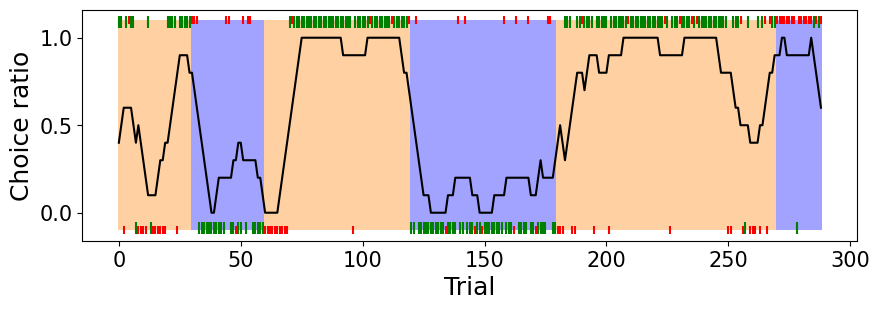

In [ ]:
session = -5 #@param
Mdata = loadmat(os.path.join('.',FNAME_))
probs = Mdata['PROBS']
probs_combined = np.vstack((1 - probs[:, session],probs[:, session], )).T

n = np.where(dataset_train._xs[:, session, 0] == -1)[0][0]
window_size = 10 #@param
choices_moving_avg = np.convolve(dataset_train._xs[0:n, session, 0], np.ones(window_size) / window_size, mode='same')
ax = bandits.plot_session(
    choices=dataset_train._xs[0:n, session, 0],
    rewards=dataset_train._xs[0:n, session, 1],
    timeseries=choices_moving_avg, #0:n, session, 0],
    timeseriesb=probs_combined[0:n,:],
    timeseries_name='Choice ratio',
)

-----modelFitting--------

In [ ]:
#@title Compute log-likelihood
def compute_log_likelihood(dataset, model_fun, params):

  xs, actual_choices = next(dataset)
  n_trials_per_session, n_sessions = actual_choices.shape[:2]
  model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

  predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :2]))

  log_likelihood = 0
  n = 0  # Total number of trials across sessions.
  for sess_i in range(n_sessions):
    for trial_i in range(n_trials_per_session):
      actual_choice = int(actual_choices[trial_i, sess_i])
      if actual_choice >= 0:  # values < 0 are invalid trials which we ignore.
        log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
        n += 1

  normalized_likelihood = np.exp(log_likelihood / n)

  print(f'Normalized Likelihood: {100 * normalized_likelihood:.1f}%')

  return normalized_likelihood

In [ ]:
#@title Calculate the log likelihoods for example parameters
test_alpha = 0.2 #@param
test_beta = 5 #@param
test_gamma = 0.1

def inverse_sigmoid(x):
  return np.log(x/(1-x))

print('Calculating the log likelihood for alpha = {} and beta = {}.'.format(test_alpha, test_beta))
params = {'hk_agent_q': {'alpha_unsigmoid': inverse_sigmoid(jnp.array([test_alpha])), 'beta': jnp.array([test_beta]), 'gamma_unsigmoid':inverse_sigmoid(jnp.array([test_gamma]))}}
_ = compute_log_likelihood(dataset_train, bandits.HkAgentQ, params)

Calculating the log likelihood for alpha = 0.2 and beta = 5.


NameError: name 'compute_log_likelihood' is not defined

In [45]:
#@title Fit parameters
use_gamma = True
use_tau= True
importlib.reload(bandits)
rl_params, _ = rnn_utils.fit_model(
    model_fun=bandits.HkAgentQ,
    dataset=dataset_train,
    loss_fun='categorical',
    optimizer=optax.adam(1e-1),
    convergence_thresh=1e-5,
    n_steps_per_call=100,
    n_steps_max=5000,
    use_gamma=use_gamma,
    use_tau=use_tau)

print(rl_params['hk_agent_q'])
print("Parameters:", rl_params)

Step 100 of 100; Loss: 3.8418e+03. (Time: 0.4s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 100 of 100; Loss: 3.8418e+03. (Time: 0.4s)
Model Converged! Time elapsed = 9e-06s.
{'alpha_unsigmoid': Array([-1.9441158], dtype=float32), 'beta': Array([3.9004571], dtype=float32), 'gamma_unsigmoid': Array([-0.16131985], dtype=float32), 'tau': Array([1.0917045], dtype=float32)}
Parameters: {'hk_agent_q': {'alpha_unsigmoid': Array([-1.9441158], dtype=float32), 'beta': Array([3.9004571], dtype=float32), 'gamma_unsigmoid': Array([-0.16131985], dtype=float32), 'tau': Array([1.0917045], dtype=float32)}}


In [46]:
fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
fit_beta = rl_params['hk_agent_q']['beta'][0]
#fit_gamma = jax.nn.sigmoid(rl_params['hk_agent_q']['gamma_unsigmoid'][0])
#fit_tau = rl_params['hk_agent_q']['tau'][0]
#print('Generative beta was: ', gen_beta)
print('Recovered beta was: ', fit_beta)
#print('Generative alpha was: ', gen_alpha)
print('Recovered alpha was: ', fit_alpha)

if use_gamma:
  fit_gamma = jax.nn.sigmoid(rl_params['hk_agent_q']['gamma_unsigmoid'][0])
  print('Recovered gamma was: ', fit_gamma)

if use_tau:
  fit_tau = rl_params['hk_agent_q']['tau'][0]
  print('Recovered tau was: ', fit_tau)  


Recovered beta was:  3.9004571
Recovered alpha was:  0.1251964
Recovered gamma was:  0.45975727
Recovered tau was:  1.0917045


<Axes: xlabel='Trial', ylabel="Fit Model's Q-Values">

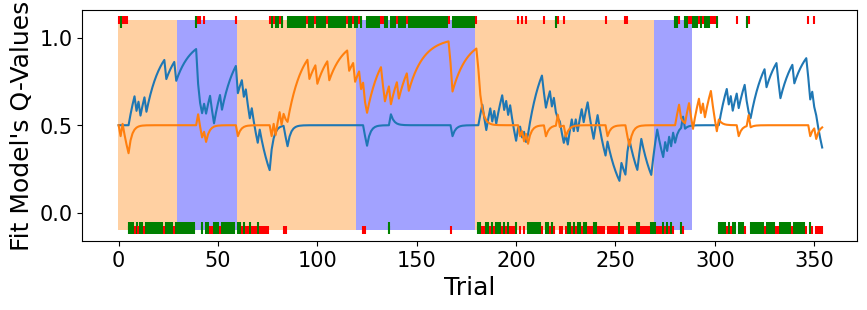

In [53]:
#@title Plot internal workings (latents) of the generating fitted model (aka the Q-values).
# Run the agent on a session

# Plot session
session=-4
xs = dataset_train._xs
network_outputs, network_states = rnn_utils.eval_model(bandits.HkAgentQ, rl_params, xs)
network_states = np.array(network_states)
trial_end = rnn_utils.find_session_end(xs[:, session, 0])
choices = xs[:trial_end, session, 0]
rewards = xs[:trial_end, session, 1]
rl_activations = network_states[:trial_end, session, :]
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=rl_activations,
    timeseries_name="Fit Model's Q-Values",
    timeseriesb=probs_combined[0:n,:],
    )

In [172]:
#@title Fit parameters session by session
use_gamma = False
use_tau = False
importlib.reload(bandits)

# Initialize a dictionary to store parameters for each session
session_params = {}
num_sessions = dataset_train._xs.shape[1]
param_matrix = np.zeros((num_sessions, 4))  # 4 columns for alpha, beta, gamma, and tau


# Iterate over each session in the dataset
for session in range(dataset_train._xs.shape[1]):
    print(f"Fitting session {session + 1}/{dataset_train._xs.shape[1]}")
    
    # Extract data for the current session
    xs_session = dataset_train._xs[:, session, :]
    ys_session = dataset_train._ys[:, session, :]
    xs_session = xs_session.reshape(xs_session.shape[0], 1, xs_session.shape[1])
    ys_session = ys_session.reshape(ys_session.shape[0], 1, ys_session.shape[1])
  
    # Create a dataset for the current session
    dataset_session = rnn_utils.DatasetRNN(xs_session, ys_session)
    
    # Fit the model for the current session
    rl_params, _ = rnn_utils.fit_model(
        model_fun=bandits.HkAgentQ,
        dataset=dataset_session,
        loss_fun='categorical',
        optimizer=optax.adam(1e-1),
        convergence_thresh=1e-5,
        n_steps_per_call=100,
        n_steps_max=5000,
        use_gamma=use_gamma,
        use_tau=use_tau)
    
    # Store the parameters for the current session
    session_params[f'session_{session + 1}'] = rl_params

    # Extract alpha, beta, gamma, and tau and store them in the param_matrix
    alpha = float(jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0]))
    beta = float(rl_params['hk_agent_q']['beta'][0])
    if use_gamma:
        gamma = float(jax.nn.sigmoid(rl_params['hk_agent_q']['gamma_unsigmoid'][0]))
    else:
        gamma = np.nan
    if use_tau:
        tau = float(rl_params['hk_agent_q']['tau'][0]) # Use np.nan if tau is not present
    else:
        tau = np.nan
    param_matrix[session, :] = [alpha, beta, gamma, tau]


# Print the parameters for each session
for session, params in session_params.items():
    print(f"Parameters for {session}: {params['hk_agent_q']}")

Fitting session 1/18
Step 100 of 100; Loss: 1.5007e+01. (Time: 0.1s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 7e-06s.
Step 100 of 100; Loss: 1.4451e+01. (Time: 0.1s)
Model not yet converged (convergence_value = 0.03706902) - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 100 of 100; Loss: 1.4252e+01. (Time: 0.1s)
Model not yet converged (convergence_value = 0.01374173) - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 100 of 100; Loss: 1.4144e+01. (Time: 0.1s)
Model not yet converged (convergence_value = 0.007556448) - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 100 of 100; Loss: 1.4075e+01. (Time: 0.1s)
Model not yet converged (convergence_value = 0.00491298) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 100 of 100; Loss: 1.4026e+01. (Time: 0.1s)
Model not yet converged (convergence_value = 0.003512582) - Running more steps of gradient descent. Time elapsed 

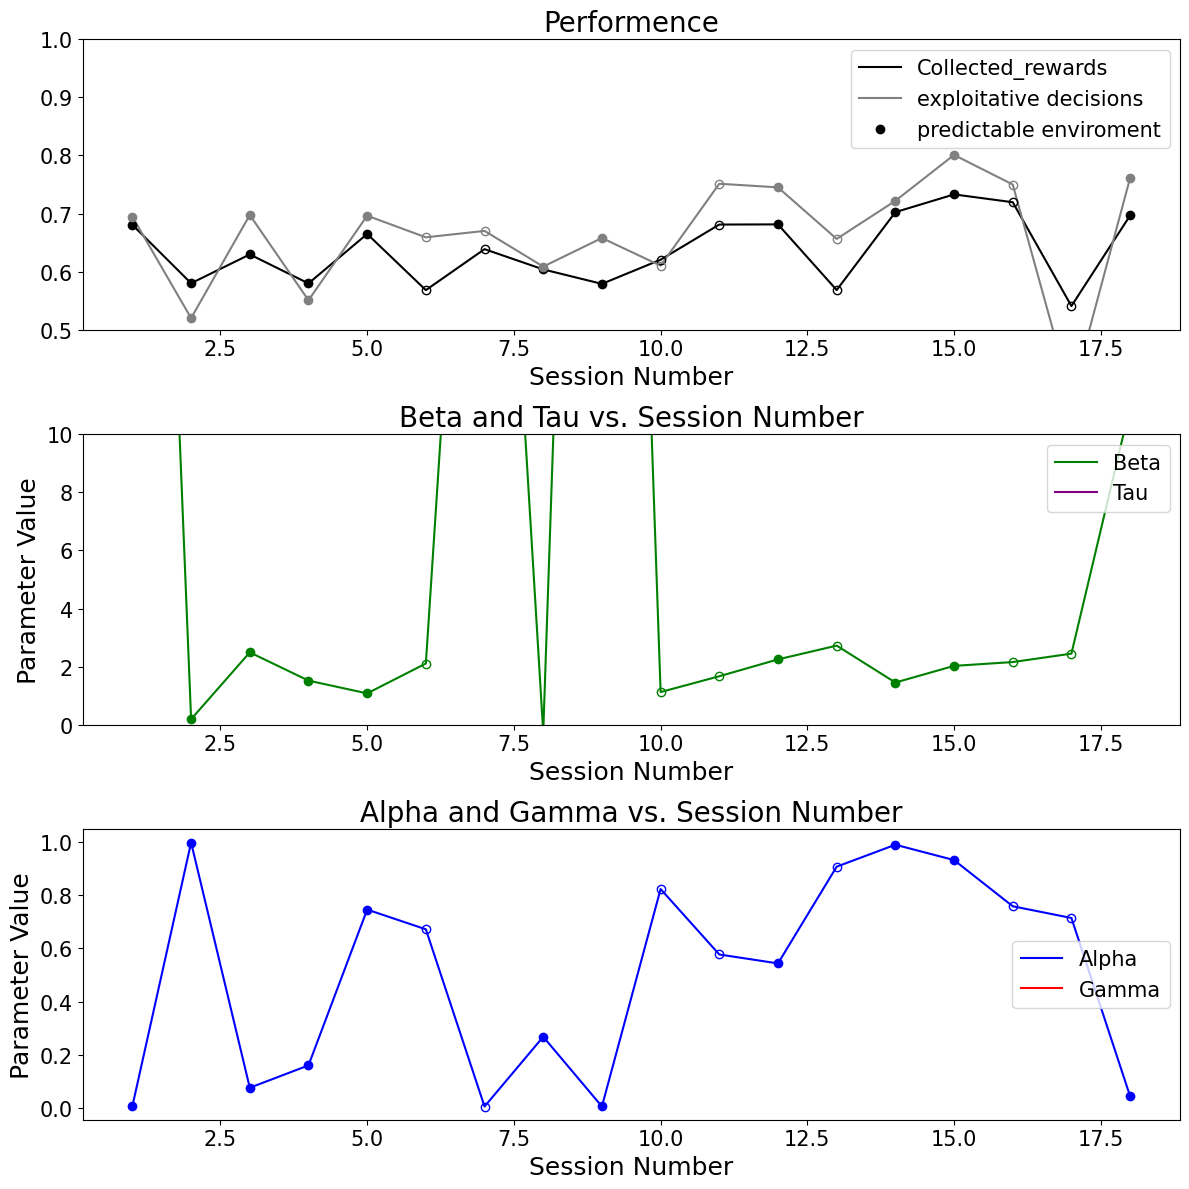

In [ ]:
import matplotlib.pyplot as plt

Mdata = loadmat(os.path.join('.',FNAME_))
probs = Mdata['PROBS']
probs_combined = np.vstack((1 - probs[:, :],probs[:, :], )).T
mask = np.any((probs != 0.9) & (probs != 0.1) & (probs != 0.0)  & (~np.isnan(probs)), axis=0)
env2 = np.where(mask)[0]

Mdata = loadmat(os.path.join('.',FNAME_))
decisons = Mdata['OUTPUT']
# Create a mask to filter out -1 elements
valid_mask = decisons[:, :, 1] != -1
# Calculate collected rewards, omitting -1 elements
collected_rewards = sum(decisons[:, :, 1] * valid_mask) / sum(valid_mask)#np.sum(decisons[:, :, 1] * [valid_mask], axis=0)
likelymask = probs < 0.5
likelysidedec = (sum(decisons[:, :, 0]*(~likelymask)*(valid_mask)) + sum((1-decisons[:, :, 0])*(likelymask)*(valid_mask)) )/ sum(valid_mask)

# Extract the parameters from the param_matrix
alpha_values = param_matrix[:, 0]
beta_values = param_matrix[:, 1]
gamma_values = param_matrix[:, 2]
tau_values = param_matrix[:, 3]

# Create a range for the session numbers
session_numbers = np.arange(1, num_sessions + 1)

# Plot the parameters vs. session number on the same plot with different colors
plt.figure(figsize=(12, 12))

alpha_filled_label_added = True
perform_filled_label_added = False

# Plot beta and tau on the first subplot
plt.subplot(3, 1, 1)
plt.plot(session_numbers, collected_rewards, linestyle='-', label='Collected_rewards', color='black')
plt.plot(session_numbers, likelysidedec, linestyle='-', label='exploitative decisions', color='gray')
for session in session_numbers:
    marker = 'o' if session - 1 in env2 else 'o'
    facecolor = 'none' if session - 1 in env2 else 'black'
    if not perform_filled_label_added:
        perform_filled_label_added = True
        label = 'noisy enviroment' if session - 1 in env2 else 'predictable enviroment'
        plt.plot(session, collected_rewards[session - 1], marker=marker, linestyle='None', color='black', markerfacecolor=facecolor, label = label)
    else:
        plt.plot(session, collected_rewards[session - 1], marker=marker, linestyle='None', color='black', markerfacecolor=facecolor)
    facecolor = 'none' if session - 1 in env2 else 'gray'
    plt.plot(session, likelysidedec[session - 1], marker=marker, linestyle='None', color='gray', markerfacecolor=facecolor)
plt.xlabel('Session Number')
plt.title('Performence')
plt.legend()
plt.grid(True)
plt.ylim([0.5, 1])

plt.subplot(3, 1, 2)
plt.plot(session_numbers, beta_values, linestyle='-', label='Beta', color='green')
plt.plot(session_numbers, tau_values, linestyle='-', label='Tau', color='purple')
for session in session_numbers:
    marker = 'o' if session - 1 in env2 else 'o'
    facecolor = 'none' if session - 1 in env2 else 'green'
    plt.plot(session, beta_values[session - 1], marker=marker, linestyle='None', color='green', markerfacecolor=facecolor)
    facecolor = 'none' if session - 1 in env2 else 'purple'
    plt.plot(session, tau_values[session - 1], marker=marker, linestyle='None', color='purple', markerfacecolor=facecolor)
plt.xlabel('Session Number')
plt.ylabel('Parameter Value')
plt.title('Beta and Tau vs. Session Number')
plt.legend()
plt.grid(True)
plt.ylim([0, 10])

# Plot alpha and gamma on the second subplot
plt.subplot(3, 1, 3)
plt.plot(session_numbers, alpha_values, linestyle='-', label='Alpha', color='blue')
plt.plot(session_numbers, gamma_values, linestyle='-', label='Gamma', color='red')
for session in session_numbers:
    marker = 'o' if session - 1 in env2 else 'o'
    facecolor = 'none' if session - 1 in env2 else 'blue'
    if not alpha_filled_label_added:
        alpha_filled_label_added = True
        label = 'noisy enviroment' if session - 1 in env2 else 'predictable enviroment'
        plt.plot(session, alpha_values[session - 1], marker=marker, linestyle='None', color='blue', markerfacecolor=facecolor, label = label)
    else:
        plt.plot(session, alpha_values[session - 1], marker=marker, linestyle='None', color='blue', markerfacecolor=facecolor)
    facecolor = 'none' if session - 1 in env2 else 'red'
    plt.plot(session, gamma_values[session - 1], marker=marker, linestyle='None', color='red', markerfacecolor=facecolor)
plt.xlabel('Session Number')
plt.ylabel('Parameter Value')
plt.title('Alpha and Gamma vs. Session Number')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

-------- RRN -----------

In [67]:
#@title Set up the RNN (GRU) Model
n_hidden = 16  #@param
def make_gru():
  model = hk.DeepRNN(
      [hk.GRU(n_hidden), hk.Linear(output_size=2)]
  )
  return model

In [68]:
#@title Set up the RNN (Low-Rank RNN) Model
n_hidden = 16  #@param
rank = 4  #@param

# Define the Low-Rank RNN class
class LowRankRNN(hk.RNNCore):
    def __init__(self, n_hidden, rank):
        super().__init__()
        self.n_hidden = n_hidden
        self.rank = rank

    def __call__(self, inputs, state):
        # Decompose the weight matrix into two smaller matrices
        W1 = hk.Linear(self.rank)(inputs)
        W2 = hk.Linear(self.n_hidden)(W1)
        new_state = jax.nn.tanh(W2 + state)
        return new_state, new_state

    def initial_state(self, batch_size):
        return jnp.zeros([batch_size, self.n_hidden])

def make_low_rank_rnn():
  model = hk.DeepRNN(
      [LowRankRNN(n_hidden, rank=4), hk.Linear(output_size=2)]
  )
  return model


def initialize_low_rank_rnn_params(gru_params, rank):
    low_rank_rnn_params = {}

    for module_name, module_params in gru_params.items():
        low_rank_rnn_params[module_name] = {}
        for param_name, param_value in module_params.items():
            if param_value.ndim == 2:  # Check if the parameter is a 2-dimensional array
                # Perform SVD on the weight matrix
                U, S, Vt = np.linalg.svd(param_value, full_matrices=False)
                # Keep only the top 'rank' singular values
                U = U[:, :rank]
                S = np.diag(S[:rank])
                Vt = Vt[:rank, :]
                # Initialize the low-rank parameters
                low_rank_rnn_params[module_name][param_name + '_U'] = U
                low_rank_rnn_params[module_name][param_name + '_S'] = S
                low_rank_rnn_params[module_name][param_name + '_Vt'] = Vt
            else:
                # Copy the bias and other parameters directly
                low_rank_rnn_params[module_name][param_name] = param_value

    return low_rank_rnn_params


In [69]:
#@title Fit the RNN (GRU) model
n_steps_max = 5000 #@param
optimizer = optax.adam(learning_rate=1e-2)
gru_params, _ = rnn_utils.fit_model(
    model_fun=make_gru,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max,
    use_gamma=False,
    use_tau=False)

Step 500 of 500; Loss: 8.9008e+03. (Time: 7.5s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 8.7015e+03. (Time: 7.7s)
Model not yet converged (convergence_value = 0.02238992) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 8.4502e+03. (Time: 7.7s)
Model not yet converged (convergence_value = 0.02887097) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 8.7888e+03. (Time: 7.6s)
Model not yet converged (convergence_value = 0.04006725) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 8.4700e+03. (Time: 7.6s)
Model not yet converged (convergence_value = 0.03627209) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 8.1205e+03. (Time: 7.5s)
Model not yet converged (convergence_value = 0.04126651) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 5

<Axes: xlabel='Trial', ylabel='Network Activations'>

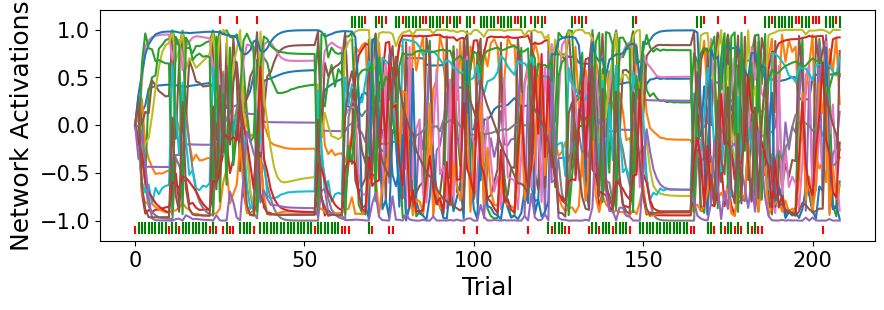

In [74]:
#@title Plot internal workings of the model
# Run the agent on a session
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_gru, gru_params, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0

trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
gru_activations = network_states[:trial_end, 0, sess_i, :]
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=gru_activations,
    
    timeseries_name='Network Activations')

In [75]:
# Initialize the low-rank RNN with the trained GRU parameters
rank = 4
low_rank_rnn_params = initialize_low_rank_rnn_params(gru_params, rank)

# Fine-tune the low-rank RNN
low_rank_rnn_params, _ = rnn_utils.fit_model(
    model_fun=make_low_rank_rnn,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max,
    use_gamma=False,
    use_tau=False)

Step 500 of 500; Loss: 9.5873e+03. (Time: 3.3s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 9.4621e+03. (Time: 3.2s)
Model not yet converged (convergence_value = 0.01305311) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 9.4152e+03. (Time: 3.2s)
Model not yet converged (convergence_value = 0.004960779) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 9.4000e+03. (Time: 3.2s)
Model not yet converged (convergence_value = 0.001616925) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 9.3802e+03. (Time: 3.3s)
Model not yet converged (convergence_value = 0.00210149) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 9.3656e+03. (Time: 3.3s)
Model not yet converged (convergence_value = 0.00155924) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of

<Axes: xlabel='Trial', ylabel='Network Activations'>

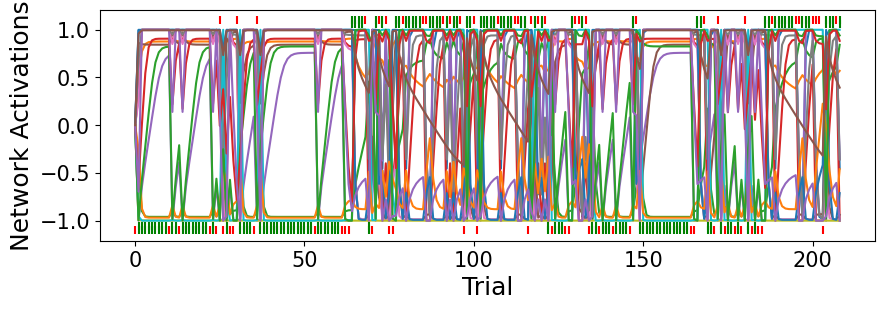

In [76]:
#@title Plot internal workings of the model
# Run the agent on a session
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_low_rank_rnn, low_rank_rnn_params, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0

trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
gru_activations = network_states[:trial_end, 0, sess_i, :]
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=gru_activations,
    timeseries_name='Network Activations')

In [ ]:
#@title Synthesize a dataset using the fit network
gru_agent = bandits.AgentNetwork(make_gru, gru_params)
_, experiment_list_gru = bandits.create_flip_dataset(gru_agent, environment, n_trials_per_session, n_sessions)

In [77]:
#@title Set up Disentangled RNN.
#@markdown Number of latent units in the model.
latent_size = 5  #@param

#@markdown Number of hidden units in each of the two layers of the update MLP.
update_mlp_shape = (3,3,)  #@param

#@markdown Number of hidden units in each of the two layers of the choice MLP.
choice_mlp_shape = (2,)

def make_disrnn():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2,
                          eval_mode=True)
  return model


optimizer = optax.adam(learning_rate=1e-2)

In [78]:
#@title Fit disRNN with no penalty at first, to get good quality-of-fit
#@markdown You can experiment with different values, but colab has been tested with 1000.

n_steps = 1000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=False,
    truncate_seq_length=200,
)

Step 1000 of 1000; Loss: 8.7111e+03. (Time: 74.3s)

Step 3000 of 3000; Loss: 9.2734e+03. (Time: 217.6s)

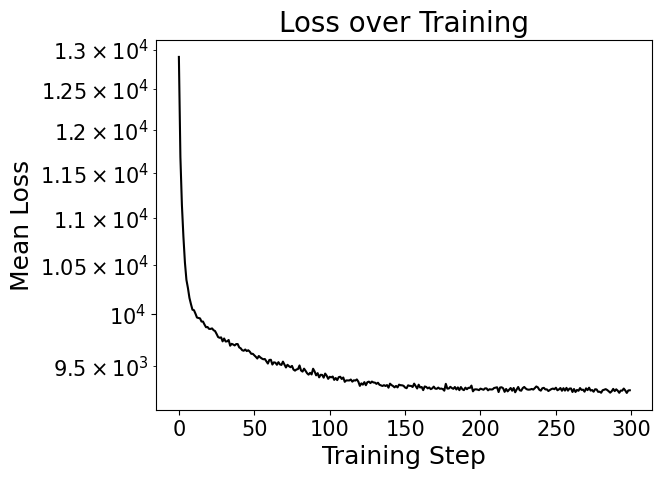

In [79]:
#@title Now fit more steps with a penalty, to encourage it to find a simple solution
#@markdown You can experiment with different values, but colab has been tested with 3000.
n_steps = 3000  #@param
information_penalty = 1e-3  #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=200,
)

<Axes: xlabel='Trial', ylabel='Network Activations'>

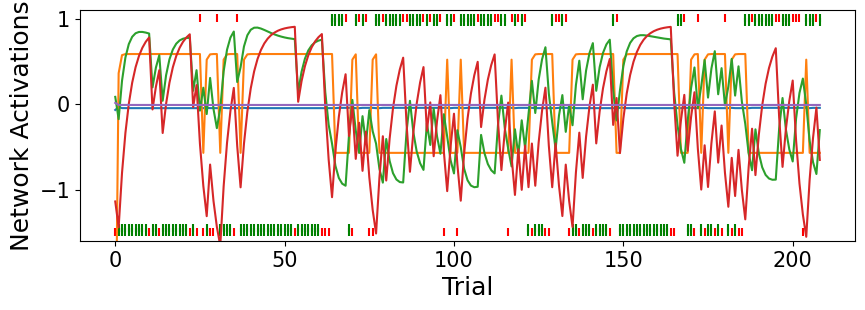

In [95]:
#@title Plot example session: latents + choices.
importlib.reload(bandits)
xs, ys = next(dataset_test)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
network_outputs, network_states = rnn_utils.eval_model(
    make_disrnn_eval, disrnn_params, xs[:trial_end, sess_i:sess_i+1])
network_states = np.array(network_states)
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
disrnn_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=disrnn_activations,
                     timeseries_name='Network Activations')

In [84]:
#@title Set up Hybrid RNN.

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_hidden_state = 'True'  #@param ['True', 'False']

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_previous_values = 'False'  #@param

#@markdown If True, learn a value for the forgetting term
fit_forget = "True"  #@param

#@markdown Learn a reward-independent term that depends on past choices.
habit_weight = 1  #@param [0, 1]

value_weight = 1.  # This is needed for it to be doing RL

rnn_rl_params = {
    's': use_hidden_state == 'True',
    'o': use_previous_values == 'True',
    'fit_forget': fit_forget == 'True',
    'forget': 0.,
    'w_h': habit_weight,
    'w_v': value_weight}
network_params = {'n_actions': 2, 'hidden_size': 16}

def make_hybrnn():
  model = hybrnn.BiRNN(rl_params=rnn_rl_params, network_params=network_params)
  return model

optimizer = optax.adam(learning_rate=1e-2)

In [85]:
#@title Fit the hybrid RNN
hybrnn_params, _ = rnn_utils.fit_model(
    model_fun=make_hybrnn,
    dataset=dataset_train,
    optimizer=optimizer,
    loss_fun='categorical',
    convergence_thresh=1e-4,
    n_steps_max=5000,
)


Step 500 of 500; Loss: 8.9316e+03. (Time: 5.1s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 8.7750e+03. (Time: 5.0s)
Model not yet converged (convergence_value = 0.01753057) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 8.8204e+03. (Time: 5.2s)
Model not yet converged (convergence_value = 0.005167805) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 8.8003e+03. (Time: 5.1s)
Model not yet converged (convergence_value = 0.002275115) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 9.1812e+03. (Time: 5.1s)
Model not yet converged (convergence_value = 0.04328226) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 8.8754e+03. (Time: 5.1s)
Model not yet converged (convergence_value = 0.03330681) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of

In [48]:
#@title Save out latent variables from the network.
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_hybrnn, hybrnn_params, xs)

h_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
v_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
h = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))
v = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))

for t in range(n_trials_per_session):
  for s in range(len(network_states)):
    h_state[t] = network_states[t][0]
    v_state[t] = network_states[t][1]
    h[t] = network_states[t][2]
    v[t] = network_states[t][3]

NameError: name 'make_hybrnn' is not defined

<Axes: xlabel='Trial', ylabel='Hybrid RNN Values'>

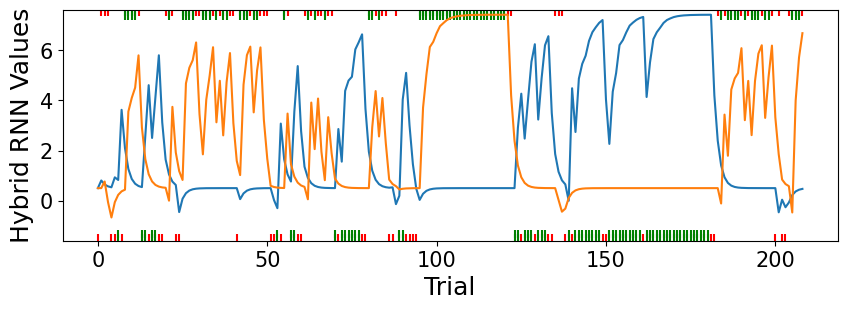

In [96]:
#@title Plot latents and simulated behavior across session for Hybrid-RNN.
sess_i = 1
choices = xs[:, sess_i, 0]
rewards = xs[:, sess_i, 1]

hybrnn_values = v[:, sess_i, :]
hybrnn_v_state = v_state[:, sess_i, :]
hybrnn_h_state = h_state[:, sess_i, :]
hybrnn_h_values = h[:, sess_i, :]


bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=hybrnn_values,
                     timeseries_name='Hybrid RNN Values')


In [ ]:
importlib.reload(rat_data)
LOCAL_PATH_TO_FILE = "/Users/kiralyb/Downloads/behavfiles/BAD17.mat"  #@param
if not os.path.exists(LOCAL_PATH_TO_FILE):
    raise ValueError('File not found.')
FNAME_ = LOCAL_PATH_TO_FILE

dataset_train, dataset_test = rat_data.format_into_datasets(
    *rat_data.load_data_for_one_rat(FNAME_, '.')[:2], rnn_utils.DatasetRNN)
n_trials_per_session, n_sessions, _ = dataset_train._xs.shape
experiment_list_train = None
experiment_list_test = None

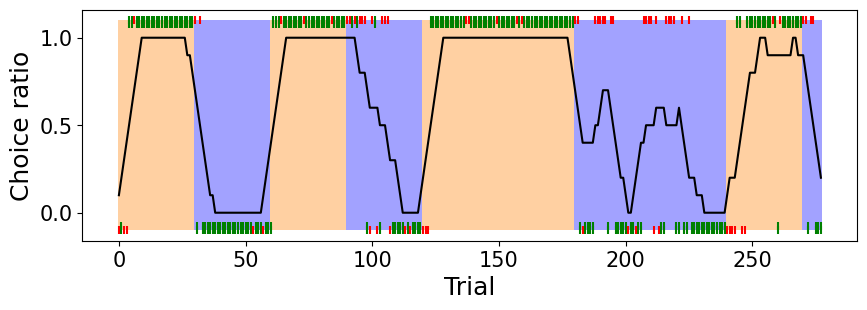

In [65]:
session = -2 #@param
Mdata = loadmat(os.path.join('.',FNAME_))
probs = Mdata['PROBS']
probs_combined = np.vstack((1 - probs[:, session],probs[:, session], )).T

n = np.where(dataset_train._xs[:, session, 0] == -1)[0][0]
window_size = 10 #@param
choices_moving_avg = np.convolve(dataset_train._xs[0:n, session, 0], np.ones(window_size) / window_size, mode='same')
ax = bandits.plot_session(
    choices=dataset_train._xs[0:n, session, 0],
    rewards=dataset_train._xs[0:n, session, 1],
    timeseries=choices_moving_avg, #0:n, session, 0],
    timeseriesb=probs_combined[0:n,:],
    timeseries_name='Choice ratio',
)

In [ ]:
import numpy as np
import scipy.io  # For saving to .mat files
import glob  # For finding all files in a directory

LOCAL_PATH = "/Users/kiralyb/Downloads/behavfiles"  #@param


#@title Fit parameters
use_gamma = False
use_tau = True
importlib.reload(bandits)
importlib.reload(rnn_utils)

# Get all .mat files in the LOCAL_PATH directory
all_files = glob.glob(os.path.join(LOCAL_PATH, "*.mat"))

for file_path in all_files:

    # Initialize a dictionary to store activations for all sessions
    all_rl_activations = {}
    # Initialize a list to store activations for all sessions
    VALUE_list = []

    # Extract the directory and animal name from the input file path
    data_dir = os.path.dirname(file_path)  # Directory where the data is located
    animal_name = os.path.splitext(os.path.basename(file_path))[0]  # Extract animal name (e.g., "BAD16")

    # Load and format the dataset for the current file
    dataset_train, dataset_test = rat_data.format_into_datasets(
        *rat_data.load_data_for_one_rat(file_path, '.')[:2], rnn_utils.DatasetRNN)

    # Extract data for the current session
    for session in range(dataset_train._xs.shape[1]):
        print(f"Processing session {session + 1}/{dataset_train._xs.shape[1]} for {animal_name}")
        # Extract data for the current session
        xs_session = dataset_train._xs[:, session, :]
        ys_session = dataset_train._ys[:, session, :]
        xs_session = xs_session.reshape(xs_session.shape[0], 1, xs_session.shape[1])
        ys_session = ys_session.reshape(ys_session.shape[0], 1, ys_session.shape[1])
        trial_end = rnn_utils.find_session_end(xs_session[:, :, 0].squeeze())
        xs_session = xs_session[:trial_end, :,:]
        ys_session = ys_session[:trial_end, :,:]

        Mdata = loadmat(os.path.join('.',file_path))
        probs = Mdata['PROBS']
        probs_combined = np.vstack((1 - probs[:, session],probs[:, session], )).T

        # Create a dataset for the current session
        dataset_session = rnn_utils.DatasetRNN(xs_session, ys_session)

        rl_params, _ = rnn_utils.fit_model(
            model_fun=bandits.HkAgentQ,
            dataset=dataset_session,
            loss_fun='categorical',
            optimizer=optax.chain(
                optax.clip_by_global_norm(0.5),  # Gradient clipping
                optax.adam(1e-2)  # Reduced learning rate
            ),
            convergence_thresh=1e-5,  # Smaller convergence threshold
            n_steps_per_call=100,  # More steps per call
            n_steps_max=5000,  # Increased maximum steps
            use_gamma=use_gamma,
            use_tau=use_tau,
            parameter_bounds={'beta': (0.0, 5.0),'tau': (0.0, 5.0)},  # Constrained bounds
       )
        

        network_outputs, network_states = rnn_utils.eval_model(bandits.HkAgentQ, rl_params, xs_session)
        network_states = np.array(network_states)

        choices = xs_session[:trial_end, :, 0].squeeze()
        rewards = xs_session[:trial_end, :, 1].squeeze()
        rl_activations = network_states[:, :, :].squeeze()

        # Append the activations for the current session to the list
        VALUE_list.append(rl_activations)  # Store each session as a separate array

        ax = bandits.plot_session(
            choices=choices, rewards=rewards, timeseries=rl_activations,
            timeseries_name="Fit Model's Q-Values",
            timeseriesb=probs_combined[0:trial_end, :],
            labels=[f'Q({"↓" if a == 0 else "↑"})' for a in range(2)]
        )
        fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
        fit_beta = rl_params['hk_agent_q']['beta'][0]
        fit_gamma = 0
        fit_tau = 0
        if use_gamma:
            fit_gamma = jax.nn.sigmoid(rl_params['hk_agent_q']['gamma_unsigmoid'][0])

        if use_tau:
            fit_tau = rl_params['hk_agent_q']['tau'][0]

        parameter_text = (
            f"α = {fit_alpha:.2f} \n"
            f"β = {fit_beta:.2f} \n"
            f"γ = {fit_gamma:.2f} \n"
            f"τ = {fit_tau:.2f}"
        )
        ax.text(1.0, 0.0, parameter_text, ha='left', va='bottom', fontsize=10,
            transform=ax.figure.transFigure,  # Use figure coordinates
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        # Save the plot as a PNG image in the "VALUES" folder
        fig_filename = os.path.join(values_dir, f"{animal_name}_session{session+1}_fit.png")
        behav_dir = os.path.join(data_dir, f"{animal_name}")
        fig_filename = os.path.join(behav_dir, f"{animal_name}_session{session+1}_fit.png")
        os.makedirs(behav_dir, exist_ok=True)  # Create the folder if it doesn't exist
        ax.figure.savefig(fig_filename, bbox_inches='tight')
        plt.close(ax.figure)
        
    
    # Add SESSIONIDs to the dictionary
    all_rl_activations['SESSIONIDs'] = Mdata['SESSIONIDs']
    all_rl_activations['VALUE'] = VALUE_list  # Store the big matrix

    # Create a "VALUES" folder in the original directory
    values_dir = os.path.join(data_dir, "VALUES")
    os.makedirs(values_dir, exist_ok=True)  # Create the folder if it doesn't exist

    # Save the activations to a .mat file in the "VALUES" folder
    output_file = os.path.join(values_dir, f"{animal_name}_values.mat")
    scipy.io.savemat(output_file, all_rl_activations)

Processing session 1/18 for BAD3
Step 500 of 500; Loss: -0.0000e+00. (Time: 0.6s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: -0.0000e+00. (Time: 0.3s)
Model not yet converged (convergence_value = nan) - Running more steps of gradient descent. Time elapsed = 3e-05s.
Step 500 of 500; Loss: -0.0000e+00. (Time: 0.3s)
Model not yet converged (convergence_value = nan) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: -0.0000e+00. (Time: 0.3s)
Model not yet converged (convergence_value = nan) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: -0.0000e+00. (Time: 0.3s)
Model not yet converged (convergence_value = nan) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: -0.0000e+00. (Time: 0.3s)
Model not yet converged (convergence_value = nan) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed